# Random Ronchigram generator

**Note**: In order to use it on a specific machine, you should build machine interface (setX and get_state functions).


In [1]:
# GPT related libraries
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle
import numpy as np
from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import os
sys.path.insert(1, '/home/cz489/STEMalign_BO/GPTrelated') 
saveResultsQ = False
import scipy
# import cv2

failed to import parallelstuff


In [2]:
# CNN related libraries
from keras import applications, optimizers, callbacks
from keras.models import Sequential, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import tensorflow as tf

Using TensorFlow backend.


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

## Get CNN model ready

In [4]:
# VGG16 model with self-defined top fully-connected layers
# training data: 50,000 frames of simulated Ronchigrams, 70 mrad collection angle, 100 mrad simulation range, fine aberration range
# training hyper-parameters: 
#  learning rate: 8.5e-5/5.5e-5
#  decay: 1e-7
#  momentum: 0.9
#  batch size: 20
#  training epoch: 50/100

model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
print('Model loaded')
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.0))
top_model.add(Dense(1,activation=None))

new_model = Sequential()
for l in model.layers:
    new_model.add(l)
new_model.add(top_model)
new_model.load_weights('CNNmodels/VGG16_coarse_linear_highCs.h5')
model = new_model
del top_model, new_model

Model loaded


In [11]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input  

In [66]:
ronch = np.load('GPT_Ronchigram_list_2.npy')
emit = np.load('GPT_40mrad_emit_list_2.npy')
y_list = []
x_list = []
for i in range(len(ronch)):
    frame = ronch[i]
    frame = scale_range(frame, 0, 1)
    new_channel = np.zeros(frame.shape)
    img_stack = np.dstack((frame, new_channel, new_channel))
    x_list.append(img_stack)
    y_list.append(emit[i])

ronch = np.load('GPT_Ronchigram_list.npy')
emit = np.load('GPT_40mrad_emit_list.npy')
for i in range(len(ronch)):
    frame = ronch[i]
    frame = scale_range(frame, 0, 1)
    new_channel = np.zeros(frame.shape)
    img_stack = np.dstack((frame, new_channel, new_channel))
    x_list.append(img_stack)
    y_list.append(emit[i])
    
x_list = np.concatenate([arr[np.newaxis] for arr in x_list])
prediction =model.predict(x_list, batch_size = 10)
# prediction_fine = np.sqrt(np.exp(prediction))/(1.06e3) # case for VGG16_fine, convert unit to pm*rad
# prediction_coarse = prediction * (468.3-0.01) + 0.01 # case for VGG16_coarse, convert normalzied num to pm*rad
prediction_coarse_highCs = prediction * (2779 - 0.003) + 0.003 # case for VGG16_coarse with high Cs

Text(0, 0.5, 'CNN $\\epsilon_\\chi$ (pm•rad)')

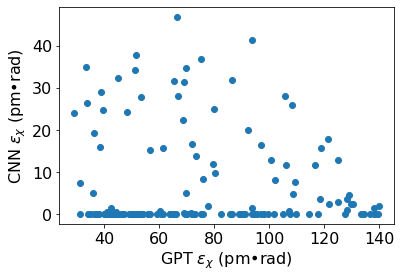

In [76]:
# plt.scatter(-np.asarray(y_list), prediction_coarse_highCs)
# plt.scatter(-np.asarray(y_list), prediction_coarse)
plt.scatter(-np.asarray(y_list), prediction_fine)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('GPT $\epsilon_\chi$ (pm\u2022rad)', fontsize = 16)
plt.ylabel('CNN $\epsilon_\chi$ (pm\u2022rad)', fontsize=16)

## Generate a serise of random Ronchigrams, then feed to CNN

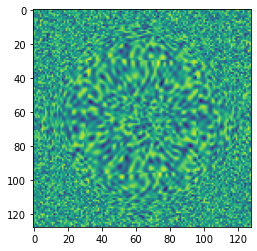

-33.11499454639152
200


In [3]:
ndim = 5 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation
dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
reps = 200  # number of times to repeat the GPT simulation with random status

iter_bounds = [(1000,2200),(-3,3),(3.87e5, 3.93e5), (-6.55e5, -6.40e5),(-3.7515e6, -3.7495e6)]  # hard coded boundary for now.
rs = np.random.RandomState()
start_point = [[x[0] + (rs.rand()*(x[1]-x[0])) for x in iter_bounds]]
# obj_list = np.linspace(-3.7491e6, -3.751e6,num=reps)

# Run GPT simulation 'reps' times
ronch = []
emit = []
start_point_list = []

for i in range(reps):
    rs = np.random.RandomState()
    start_point = [[x[0] + (rs.rand()*(x[1]-x[0])) for x in iter_bounds]]
    print(start_point)
#     start_point = [[1498, 0.5, 3.90e5, -6.54e5, obj_list[i]]]
    #creat machine interface
    mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) 
    # get emittance from getState() return value
    emit.append(mi.getState()[1][0][0])
    start_point_list.append(start_point[0])
    # get ronchigram from saved npy file
    if ~os.path.exists('ronchigram.npy'):
        time.sleep(1)
    # Make sure the output Ronchigram is set to 128px for CNN
    temp = np.load('ronchigram.npy')
    ronch.append(temp)
    clear_output(wait=True)
    plt.imshow(temp)
    plt.show()
    print(emit[-1])
    print(len(emit))
    os.remove('ronchigram.npy')
    
    
    np.save('GPT_start_point_list_x200_3.npy', start_point_list)
    np.save('GPT_Ronchigram_list_x200_3.npy', ronch)
    np.save('GPT_40mrad_emit_list_x200_3.npy', emit)

In [99]:
y_list = []
x_list = []
for i in range(len(ronch)):
    frame = ronch[i]
    frame = scale_range(frame, 0, 1)
    new_channel = np.zeros(frame.shape)
    img_stack = np.dstack((frame, new_channel, new_channel))
    x_list.append(img_stack)
    y_list.append(emit[i])
    
x_list = np.concatenate([arr[np.newaxis] for arr in x_list])
prediction =model.predict(x_list, batch_size = 10)

## CNN convergence test with different number of electrons

In [53]:
ndim = 5
ronch = []
emit = []

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# iter_bounds = [(1000,2200),(-20,20),(3.87e5, 3.91e5), (-6.55e5, -6.40e5),(-3.7511e6, -3.7497e6)]  # hard coded boundary for now.
# rs = np.random.RandomState()
# start_point = [[x[0] + (rs.rand()*(x[1]-x[0])) for x in iter_bounds]]
start_point = [[1402.3950844763335, -0.7422486649085123, 390243.25958254305, -647109.101243585, -3750595.130085018]]
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point, CNNoption=1) 
# get emittance from getState() return value
print(start_point)
print(mi.getState()[1][0][0])
# get ronchigram from saved npy file
if ~os.path.exists('ronchigram.npy'):
    time.sleep(1)
temp = np.load('ronchigram.npy')

Model loaded
[[1402.3950844763335, -0.7422486649085123, 390243.25958254305, -647109.101243585, -3750595.130085018]]
-0.11450871


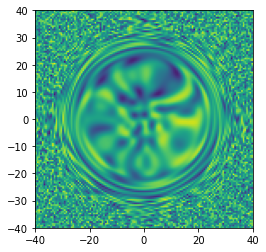

In [54]:
plt.imshow(temp, extent=[-40,40,-40,40])

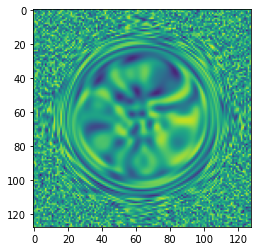

In [38]:
plt.imshow(temp)